# Point of this file is to try to develop a more correct model for a linescan of a single source
$$A\max\left(\alpha\arctan{\left(\frac{\frac{W_\text{slit}}{2}−|x|}{L}\right)},0\right)+A\max\left((1−\alpha)\arctan{\left(\frac{\frac{W_\text{scintillator}}{2}−|x|}{L}\right)},0\right)$$

The above model assumes only one thing blocking your scintillator, and does nothing about the convolution

the parameters are:
- $\alpha$ proportionality constant for how much signal gets through the gates
- $W_\text{slit}$ is the width of the slit created by the gates
- $W_\text{scintillator}$ is the width of the scintillator
- $L$ is the translational distance travelled, centered in the middle between the slits
- $A$ is the proportionality constant for total signal


In [184]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import Methods as m
import importlib
importlib.reload(m)

<module 'Methods' from '/Users/markzhitnitsky/Desktop/School/2025-26 Year/PHYS409/Experiment 1 - PET/Code/Methods.py'>

In [185]:

def singleSlit(coords, amplitude, x0, W, L):
    x = coords
    return np.maximum(amplitude * W * np.arctan((W/2 - np.abs(x-x0))/L), 0)

def stackedSlit(coords, amplitude, x0, Wslit, Wscint, L, alpha):
    return (1-alpha) * singleSlit(coords, amplitude, x0, Wslit, L) + alpha * singleSlit(coords, amplitude, x0, Wscint, L)

In [210]:
xArr = np.arange(start=-6,stop=6,step=0.05)
stackedSlitModel = []
# singleSlitModel = []
# for x in xArr:
stackedSlitModel = stackedSlit(xArr, 1500, -0.5, 3, 40, 100, 0.001)

# print(len(stackedSlitModel))
    # singleSlitModel.append(singleSlit(x, 1000, 0, 2, 100) * 0.03)
    # singleSlitModel.append(singleSlit(x, 1000, 0, 20, 100) * 0.03)


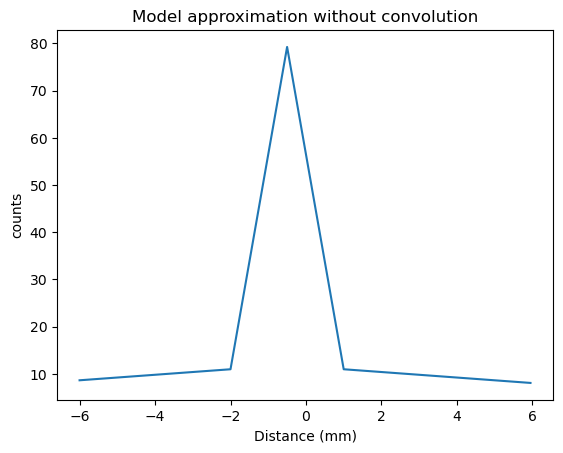

In [211]:
plt.figure()
plt.plot(xArr, stackedSlitModel)
# plt.plot(xArr, singleSlitModel)
plt.title("Model approximation without convolution")
plt.xlabel("Distance (mm)")
plt.ylabel("counts")
plt.savefig("./figures/Linescan Model.png")
plt.show()

In [212]:
# print(xArr)
dx = xArr[1] - xArr[0]  # 0.05 mm per pixel, get it from data ig
# print(dx)
sourceRadius = 0.6    # radius in mm
scintRadius = 1.0 # grid size in mm

# along a line is 4pi r^2

def get_projected_circle(radius, dx):
    # Ensure at least a small range around zero to avoid empty arrays
    limit = max(radius, dx)
    # print(limit)
    num_points = int(2 * limit / dx) + 1
    x = np.linspace(-limit, limit, num_points)
    # print(x)

    # Calculate projection
    y = 2 * np.sqrt(np.maximum(0, radius**2 - x**2))
    # print(y)

    total_area = np.sum(y) * dx
    if total_area == 0:
        # Fallback for sub-pixel sources: a discrete Delta function
        y = np.zeros_like(x)
        y[len(y)//2] = 1/dx
        return y

    return y / total_area

# Generate Kernels
kernel_source = get_projected_circle(sourceRadius, dx)       # R = 0.7mm
kernel_scint = get_projected_circle(scintRadius, dx)        # Example R = 1.2mm
# ^ This assumes scintillator is a circle, idk what shape it is

# print(kernel_scint)
# print(kernel_source)

# Step 1: Combine the two physical geometries
combined_kernel = np.convolve(kernel_source, kernel_scint, mode='full') * dx
# print(len(combined_kernel))

# Step 2: Apply to your signal
# Assumes 'signal' was sampled at the same dx
signal = stackedSlitModel
convolvedSignal = np.convolve(signal, combined_kernel, mode='same')
# print(len(convolvedSignal))

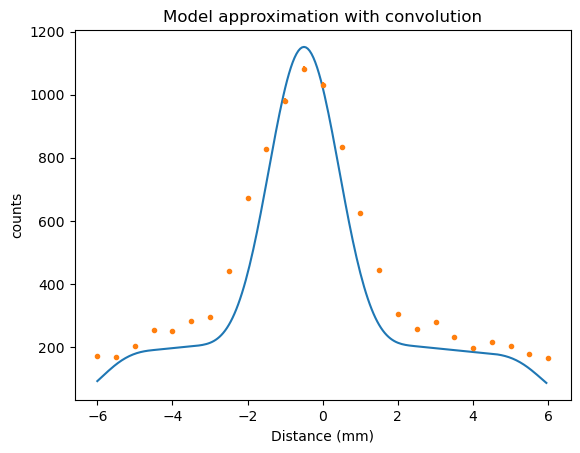

In [213]:
dist_array, counts_array, ucounts_array = m.readLineScan("./data/Resolution Measurements - 2026-01-16/Jan 19, 2026, 4_47 PM, Scan1, 0_0 Deg, w_3mm.dat")
x = dist_array
y = counts_array

plt.figure()
plt.plot(xArr, convolvedSignal)
plt.errorbar(dist_array, counts_array, yerr=ucounts_array, fmt='.', label=f"counts data")
# plt.plot(xArr, singleSlitModel)
plt.title("Model approximation with convolution")
plt.xlabel("Distance (mm)")
plt.ylabel("counts")
plt.savefig("./figures/Linescan Model with convolution.png")
plt.show()

In [214]:
xArr = np.arange(start=-100,stop=100,step=0.05)
stackedSlitModel = []
stackedSlitModel = stackedSlit(xArr, 320, 0,8, 40, 100, 0.008)
dx = xArr[1] - xArr[0]  # 0.05 mm per pixel, get it from data ig
sourceRadius = 0.7    # radius in mm
scintRadius = 2.0 # grid size in mm
# Generate Kernels
kernel_source = get_projected_circle(sourceRadius, dx)       # R = 0.7mm
kernel_scint = get_projected_circle(scintRadius, dx)        # Example R = 1.2mm
combined_kernel = np.convolve(kernel_source, kernel_scint, mode='full') * dx
signal = stackedSlitModel
convolvedSignal = np.convolve(signal, combined_kernel, mode='same')

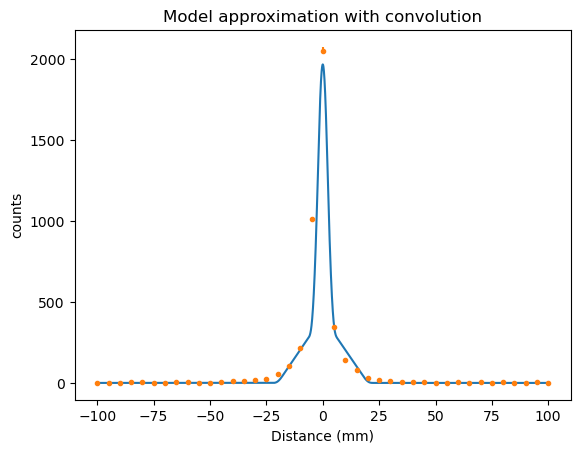

In [215]:
dist_array, counts_array, ucounts_array = m.readLineScan("./data/rando measurements/Jan 19, 2026, 3_51 PM, Scan1, 0_0 Deg, w_8mm,translate200mm.dat")
x = dist_array
y = counts_array

plt.figure()
plt.plot(xArr, convolvedSignal)
plt.errorbar(dist_array, counts_array, yerr=ucounts_array, fmt='.', label=f"counts data")
# plt.plot(xArr, singleSlitModel)
plt.title("Model approximation with convolution")
plt.xlabel("Distance (mm)")
plt.ylabel("counts")
plt.savefig("./figures/Linescan Model Wide with convolution.png")
plt.show()

In [192]:
def stackedSlitConvoluted(coords, amplitude, x0, L, alpha, sourceR, scintR):
    stepSize = 0.05  # 0.05 mm per pixel, get it from data ig
    xArr = np.arange(start=-10,stop=10,step=stepSize)
    stackedSlitSignal = []
    for x in xArr:
        stackedSlitSignal.append(stackedSlit(x, amplitude, x0, sourceR * 2, scintR * 2, L, alpha))

    dx = stepSize
    kernel_source = get_projected_circle(sourceR, dx)       # R = 0.7mm
    kernel_scint = get_projected_circle(scintR, dx)        # Example R = 1.2mm

    combined_kernel = np.convolve(kernel_source, kernel_scint, mode='full') * dx
    
    convolvedSignal = np.convolve(stackedSlitSignal, combined_kernel, mode='same')

    return convolvedSignal[coords]


In [193]:
dist_array, counts_array, ucounts_array = m.readLineScan("./data/Width calibration - 2026-01-23/Jan 23, 2026, 3_01 PM, Scan1, 0_0 Deg, w-3mm.dat")
x = dist_array
y = counts_array

# amplitude, x0, sigma_x, offset
p0 = [max(y), x[np.argmax(y)], 100, 0.03, 1, 10]

popt, pcov = curve_fit(stackedSlitConvoluted, dist_array, counts_array, sigma=ucounts_array, p0=p0)
m.plotWidthScanGaussian(dist_array, counts_array, ucounts_array, 2, popt, pcov, "Gaussian fit to w=3mm linescan")

IndexError: arrays used as indices must be of integer (or boolean) type